In [2]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

In [5]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [6]:
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [23]:
with open("./cannabinoid_receptor_data.csv") as inp:
    data = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in data:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "data"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [24]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

[12:41:47] ERROR: Explicit valence for atom # 0 C greater than permitted
[12:44:21] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:44:21] ERROR: Could not sanitize molecule ending on line 20009
[12:44:21] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:44:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[12:44:23] ERROR: Could not sanitize molecule ending on line 250947
[12:44:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[12:44:23] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:44:23] ERROR: Could not sanitize molecule ending on line 258130
[12:44:23] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:44:23] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[12:44:23] ERROR: Could not sanitize molecule ending on line 261581
[12:44:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[12:44:23] Explicit valence for at

[12:44:25] ERROR: Explicit valence for atom # 2 O, 3, is greater than permitted
[12:44:25] Explicit valence for atom # 6 B, 4, is greater than permitted
[12:44:25] ERROR: Could not sanitize molecule ending on line 541262
[12:44:25] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[12:44:26] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[12:44:26] ERROR: Could not sanitize molecule ending on line 557517
[12:44:26] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[12:44:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:44:26] ERROR: Could not sanitize molecule ending on line 561344
[12:44:26] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:44:26] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19

[12:44:26] ERROR: Could not sanitize molecule ending on line 562947
[12:44:26] ERROR: Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19

[12:44:26] Explicit valence for atom # 27 N, 4, is greater than 

In [25]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *data), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

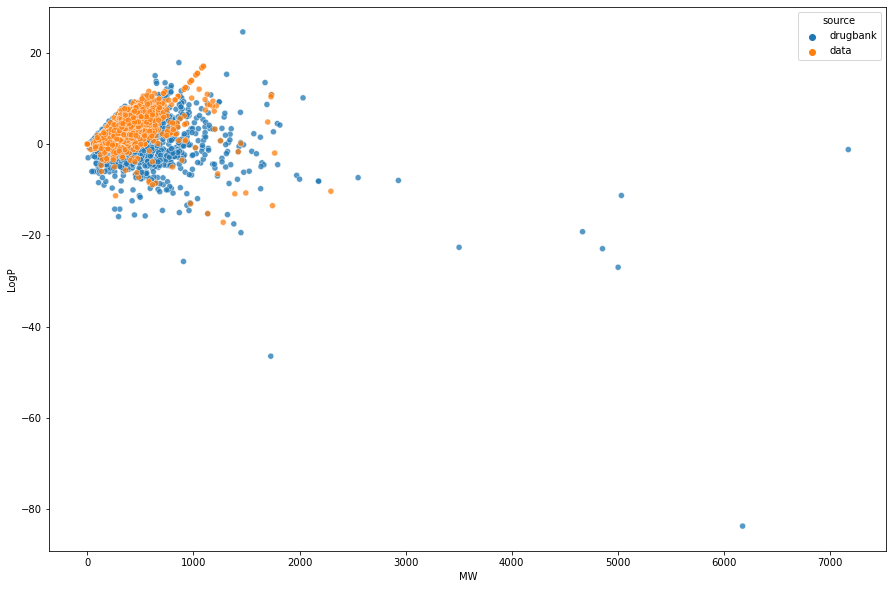

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

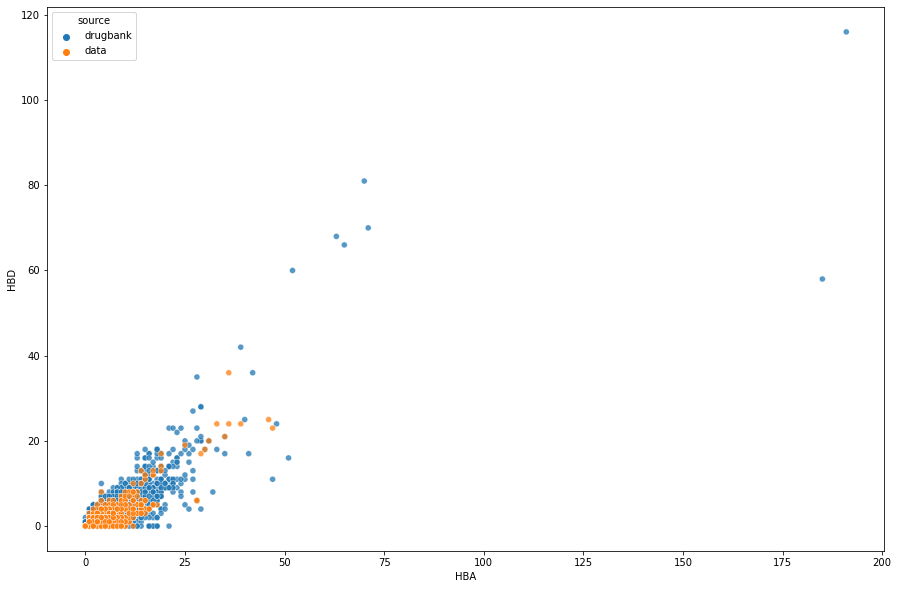

In [27]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [28]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [29]:
df.head()

,index,Smiles,source,rdmol,fps,pChEMBL_value,HBA,HBD,MW,LogP,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f2cb7a3a170>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,29,28,2178.985813,-8.11643,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f2cb7a3a260>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,16,17,1268.641439,-3.10570,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f2cb7a3a300>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.0,15,14,1068.426955,-4.13203,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f2cb7a3a3a0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,16,17,1429.669818,-0.50613,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f2cb7a3a490>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.0,12,5,1201.841368,3.26900,...,0,0,0,0,0,0,0,1,0,0


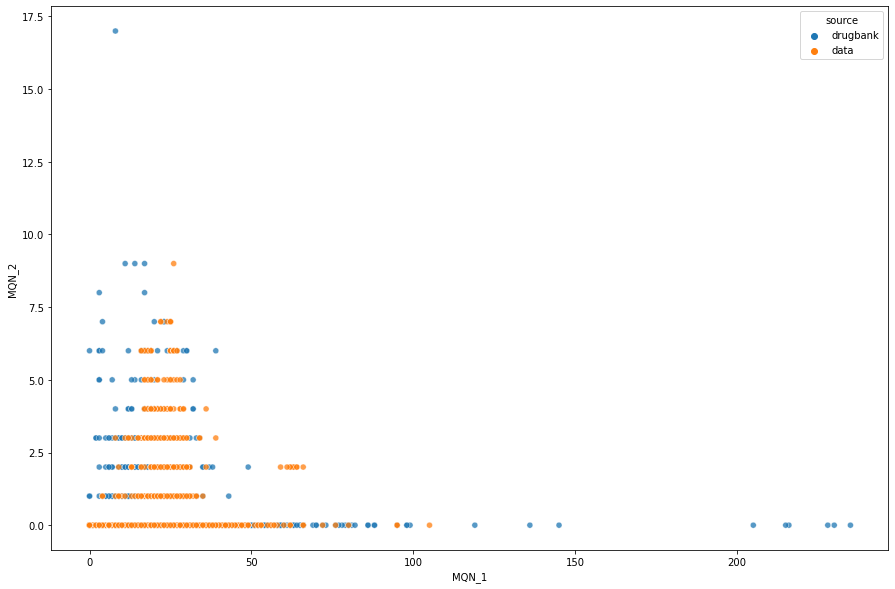

In [30]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [31]:
#tu je sns.pairplot, moving on

In [34]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

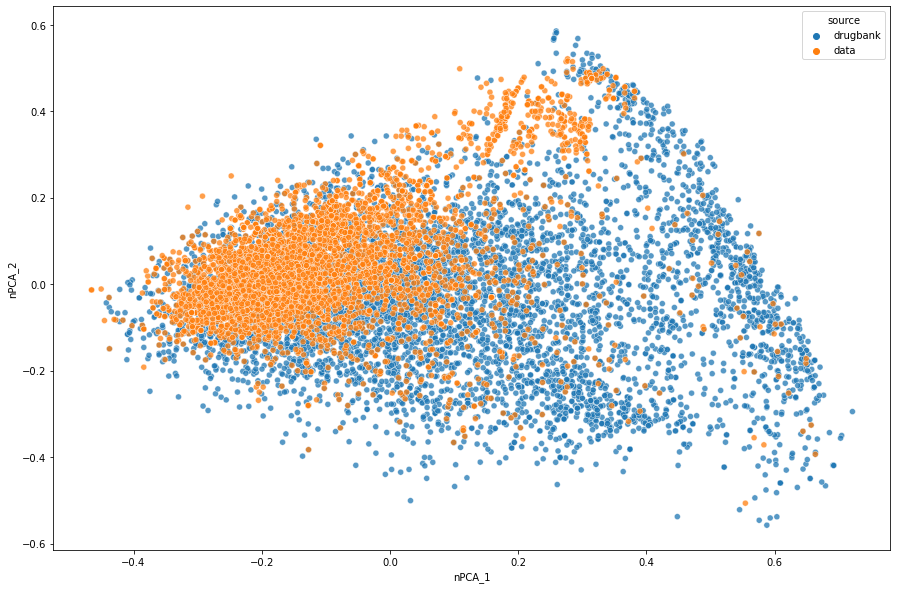

In [35]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [36]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [37]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

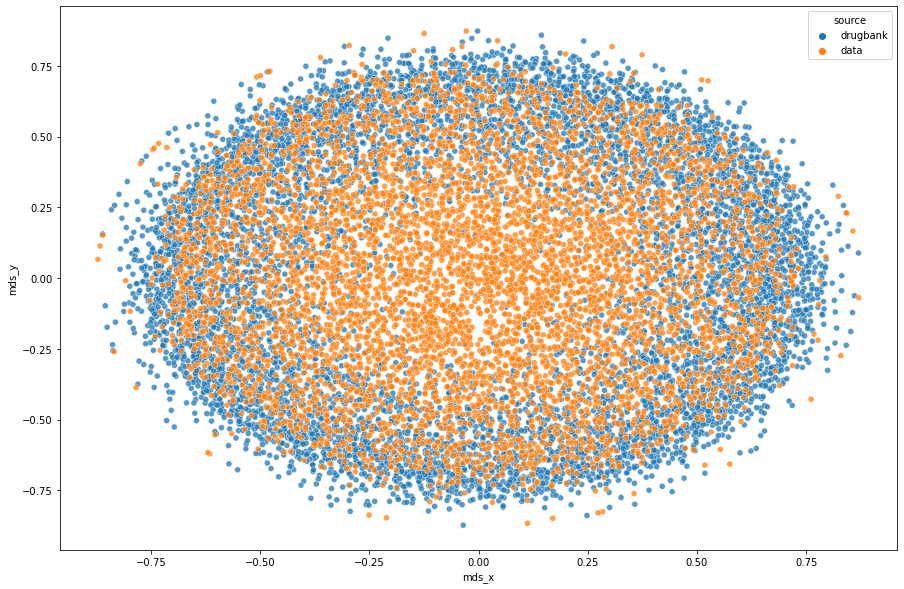

In [38]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [39]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [40]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

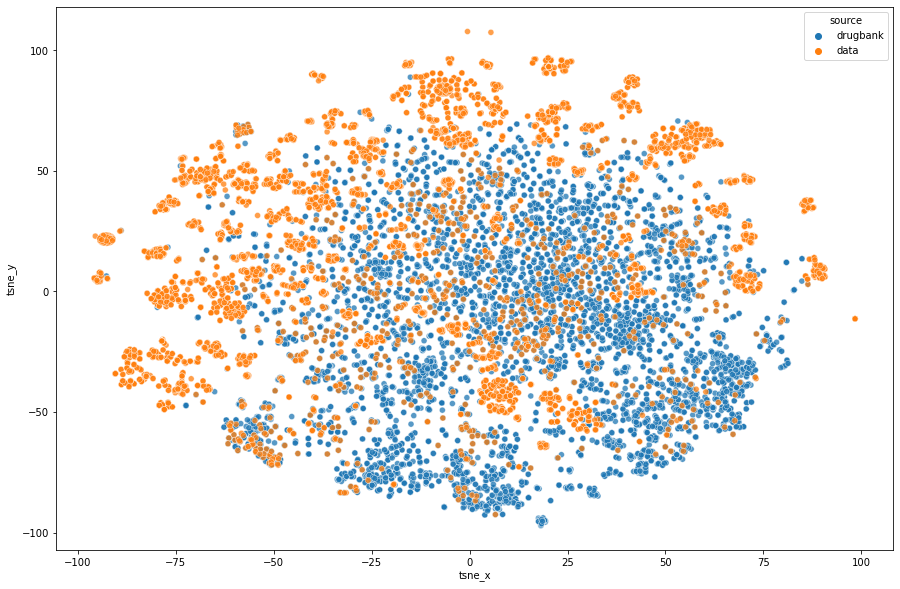

In [41]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )